In [1]:
!pip install kiwipiepy
!pip install python-mecab-ko
!pip install rank-bm25
!pip install konlpy

In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix
from multiprocessing import Pool, cpu_count
from kiwipiepy import Kiwi
from transformers import AutoModelForSequenceClassification
from rank_bm25 import BM25Okapi
import torch
import time
from konlpy.tag import Okt
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel
from transformers import AutoTokenizer, AutoModel
from safetensors.torch import load_file
from sklearn.metrics.pairwise import cosine_similarity
import os
import pickle

In [3]:
df = pd.read_csv('/kaggle/input/merge-1-6/merge_1_6_Deduplication_cleaned_index.csv')

In [4]:
tokenizer = AutoTokenizer.from_pretrained('/kaggle/input/kosimcse')
model = AutoModel.from_pretrained('/kaggle/input/kosimcse')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df['전문'] = df['전문'].fillna('')

In [5]:
save_path = '/kaggle/input/chunk-embedding/chunk_embeddings_1_6_512_64.pt'
checkpoint = torch.load(save_path)
chunk_embeddings = checkpoint['chunk_embeddings']
chunk_to_doc = checkpoint['chunk_to_doc']

In [6]:
okt = Okt()
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s가-힣]', '', text)
    text = text.lower()
    #text = ' '.join(okt.morphs(text))
    return text

def chunk_text(text, chunk_size=512, overlap=128):
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        chunks.append(chunk)
        if i + chunk_size >= len(words):
            break
    return chunks

def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
    return cls_embedding

In [7]:
def bm_preprocess_text(text):
    text=re.sub(r'\s+',' ', text)
    text=re.sub(r'[^\w\s]', '', text) 
    text=' '.join([morph[0] for morph in kiwi.tokenize(text)])
    return text

kiwi = Kiwi()

with open('/kaggle/input/bm25-model/bm25_model_1_6.pkl', 'rb') as file:
    bm25_loaded = pickle.load(file)

def bm_chunk_text(sentences, max_length=512):
    chunks = []
    current_chunk = []
    current_length = 0
    
    for sentence in sentences:
        # Kiwi를 사용하여 문장을 토크나이징
        sentence_tokens = kiwi.tokenize(sentence)
        # 토큰을 리스트로 변환 (형태소 분석 결과에서 형태소만 추출)
        sentence_tokens = [token.form for token in sentence_tokens]
        
        # 현재 길이에 따라 청크 생성
        if current_length + len(sentence_tokens) > max_length:
            chunks.append(" ".join(current_chunk))  # 토큰을 공백으로 연결하여 문자열로 변환
            current_chunk = sentence_tokens
            current_length = len(sentence_tokens)
        else:
            current_chunk.extend(sentence_tokens)
            current_length += len(sentence_tokens)
    
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    
    return chunks

# Hierarchical Approach 방식(bm25에서 top20 추출한 결과로 코사인 유사도로 top5 추출)

In [8]:
def cos_search_query(query, bm_results, chunk_embeddings, chunk_to_doc, top_k=5):
    query = preprocess_text(query)
    query_embedding = encode_text(query).unsqueeze(0).to(device)

    query_embedding_cpu = query_embedding.cpu()
    chunk_embeddings_cpu = chunk_embeddings.cpu()

    similarities = cosine_similarity(query_embedding_cpu, chunk_embeddings_cpu).flatten()
    valid_doc_indices = bm_results['번호'].values
    valid_indices = [i for i in range(len(chunk_to_doc)) if chunk_to_doc[i] in valid_doc_indices]
    valid_similarities = similarities[valid_indices]

    search_results = bm_results[bm_results['번호'].isin([chunk_to_doc[i] for i in valid_indices])].copy()
    search_results['유사도'] = valid_similarities[:len(search_results)]

    search_results = search_results.sort_values(by='유사도', ascending=False)
    top_results = search_results.head(top_k)

    return top_results[['번호', '사건번호', '유사도']]

In [9]:
def bm_search_query(query, df, top_k=40, final_top_k=20):
    # 쿼리 전처리
    query = bm_preprocess_text(query)
    tokenized_query = query.split(" ")

    # BM25 점수 계산
    bm25_scores = bm25_loaded.get_scores(tokenized_query)

    # 상위 K개 인덱스 선택
    top_k = min(top_k, len(bm25_scores))
    top_indices = bm25_scores.argsort()[-top_k:][::-1]

    # BM25 검색 결과 생성
    bm_search_results = df.iloc[top_indices].copy()
    bm_search_results['bm25Score'] = bm25_scores[top_indices]

    # 중복 항목 제거
    bm_search_results = bm_search_results.drop_duplicates(subset=['사건번호', 'bm25Score'])

    # 중복 제거된 결과에서 상위 20개 선택
    top_results = bm_search_results.head(final_top_k)

    return top_results[['번호', '사건번호', 'bm25Score']]

In [10]:
query='피고인은 조현병으로 인해 환청, 망상, 와해된 언어, 사고 연상의 이완, 비논리적 사고, 제한된 정동, 병식 손상, 판단력 저하 등의 증상을 보이며 사물을 변별하거나 의사를 결정할 능력이 미약한 상태에서 범행을 저질렀고, 재범의 위험성이 있다. 2018. 1. 4. 진주경상대학교병원에서 조현병 진단을 받고 약물 치료를 받던 피고인은 피해자 B의 뇌가 자신의 뇌와 연결되어 있어 피해자가 움직일 때마다 극심한 고통을 받는다는 망상에 사로잡혀 피해자를 죽이기로 결심하였다. 2019. 4. 24. 08:00경 창원시 마산합포구 C 아파트 D호에서 식칼을 가지고 피해자 B의 주거지 E호로 가서 피해자에게 자꾸 올라와서 죄송하다고 말한 후, 피해자가 말도 안 되는 소리 하지 말고 내려가라고 하자 알았다고 대답하며 자신의 집으로 가는 척 하다가 방화문 뒤에 숨어 피해자가 외출하는 모습을 기다렸다. 피해자가 09:05경 외출하여 엘리베이터를 기다리던 중, 피고인은 피해자의 뒤로 조용히 접근해 식칼로 피해자의 등 부위를 1회 찌르고, 피해자가 도망가려다 복도 벽 앞에 쓰러지자 옆구리, 등, 가슴 부위 등을 22회 찔러 피해자를 사망하게 하였다. 피고인은 피해자를 살해하였다. 증거로는 피고인의 법정진술, 경찰 진술조서, 압수조서, 사망진단서, 변사현장점검목록표, 유전자감정서, 부검감정서, 정신감정결과통보, CCTV 캡쳐화면, 현장사진 등이 있다. 피고인은 2017년경부터 피해망상 등의 증상을 보였고, 2018. 1. 4.경 조현병 진단을 받았으며, 정신질환으로 인해 치료감호시설에서 치료를 받아야 하고 치료를 받지 않으면 재범의 위험성이 있다. 법령 적용은 형법 제250조 제1항(유기징역형 선택), 형법 제10조 제2항, 제55조 제1항 제3호(심신미약감경), 소년법 제2조, 제60조 제1항, 특정강력범죄의 처벌에 관한 특례법 제4조 제2항(부정기형), 형법 제48조 제1항 제1호(몰수), 치료감호 등에 관한 법률 제12조 제1항, 제2조 제1항 제1호, 형법 제10조 제2항(치료감호)이다. 변호인은 피고인이 조현병으로 사물을 변별하거나 의사를 결정할 능력이 없었다고 주장하나, 피고인이 수사기관에서 범행 내용을 구체적으로 진술하고 범행의 영향을 인식하고 있었던 점 등을 종합하면, 피고인이 심신상실 상태였다고 보기 어렵다. 따라서 변호인의 주장은 받아들여지지 않았다.'
#query = '피고인은 2020년 11월경 교차로 사이트에 게시된 광고를 보고 성명불상의 보이스피싱 조직원으로부터 채권추심 업무를 맡아 수거한 금액의 2%를 수당으로 주겠다는 제안을 받고, 그에 따라 수거책 역할을 수행하기로 하였다. 보이스피싱 조직은 기망책, 관리책, 수거책, 총책으로 구성된 점조직 형태로 운영되며, 기망책은 피해자에게 금융기관 직원을 사칭하며 거짓말로 현금을 요구하고, 관리책은 수거책을 모집하여 현금을 수거하고 입금할 계좌를 제공하며, 수거책은 피해자에게서 현금을 받아 지정된 계좌로 송금한다. 총책은 이 모든 조직원들을 관리하는 역할을 한다. 피고인은 2020년 11월 16일부터 2020년 11월 30일까지 피해자 7명에게서 총 66,697,000원을 교부받아 이를 송금하였다. 구체적으로, 성명불상의 기망책들이 금융기관 직원을 사칭하여 피해자에게 대출을 권유하거나 기존 대출금을 상환하라고 거짓말을 하고, 피해자들은 이를 믿고 현금을 준비하였다. 피고인은 이러한 기망책의 지시에 따라 피해자에게서 현금을 수거하여 송금하였다. 『2021고단938』 사건에서는 피고인이 피해자 B에게서 14,697,000원을, 『2021고단1954』 사건에서는 피해자 C에게서 2,460만 원을, 『2021고단2696』 사건에서는 피해자 D에게서 1,147만 원을, 『2021고단4512』 사건에서는 피해자 E에게서 850만 원을 교부받았다. 피고인은 이 과정에서 보이스피싱의 일환이라는 사실을 인식하고 있었으나, 제안에 응하여 범행을 방조하였다. 법령 적용으로는 형법 제347조 제1항, 제32조 제1항을 적용받아 징역형을 선택하고, 방조 감경으로 형법 제32조 제2항, 제55조 제1항 제3호가 적용되며, 경합범가중으로 형법 제37조 전단, 제38조 제1항 제2호, 제50조를 고려하여 배상신청의 각하는 소송촉진 등에 관한 특례법 제32조 제1항 제3호, 제25조 제3항 제3호에 의거한다. 피고인이 취득한 이익과 가담 정도에 따라 과실상계 또는 책임제한이 고려될 수 있다.'
#query = '안녕하세요. 저는 28세의 직장인 김상훈입니다. 최근에 제가 연루된 사건이 완벽하게 무죄로 판명될 수 있을지 고민하고 있습니다. 제 상황은 다음과 같습니다: 사건 종류: 경미한 폭행  혐의 내용: 동네에서의 작은 시비로 인해 상대방에게 폭행을 가했다는 주장  사건 경위: 상대방이 저를 지속적으로 괴롭히며 욕설을 했고, 결국 감정이 격해져서 상대방의 팔을 잡은 것에 대한 문제  피해 정도: 상대방에게는 경미한 타박상이 있었지만, 저에게는 정신적인 스트레스가 큼  증거: 사건 당시 주변 사람들의 목격자 진술이 있으며, 저의 행동이 방어적이었다는 점을 강조  자수 여부: 경찰 조사에 성실히 응답하며, 사건의 경위를 상세히 설명  반성 여부: 상황이 안타깝지만, 저는 오히려 저를 방어하기 위한 행동이었다고 주장함  너무 억울합니다. 무죄를 받을 수 있을까요?'
#query = '피고인은 보이스피싱 조직원과 공모한 사실이 없고, 피해자들을 기망하지 않았다고 주장하며 원심판결에 사실오인의 위법이 있다고 항소하였다. 또한, 원심의 형(징역 8월)이 너무 무겁다고 주장했다. 반면 검사는 원심의 형이 너무 가볍다고 항소했다. 법원은 피고인의 사실오인 주장에 대해 원심에서 이미 동일한 주장이 배척되었고, 원심판결의 판단이 정당하여 피고인의 주장이 이유 없다고 판단했다. 피고인과 검사의 양형부당 주장에 대해서는 피고인이 범행으로 얻은 이익이 편취금액의 일부에 불과하고, 보이스피싱 범죄에 대한 확정적인 인식이 없었다고 보이나, 보이스피싱 범죄의 사회적 해악이 크고, 하위 조직원들도 엄히 처벌할 필요가 있다고 판단했다. 피고인은 범행을 부인하며 반성하지 않았고, 피해 회복을 위한 조치도 취하지 않았으며, 사기죄로 징역형의 집행유예와 벌금형을 받은 전과가 있고, 보이스피싱 관련 범죄로 수사를 받은 전력도 있다. 이를 종합하여 법원은 원심의 형이 너무 가볍다고 판단해 검사의 항소를 이유 있다고 보고 원심판결을 파기하였다. 법원은 형사소송법 제369조에 따라 원심판결의 범죄사실 및 증거의 요지를 그대로 인용하고, 형법 제347조 제1항, 제30조에 따라 징역형을 선택하였으며, 경합범 가중으로 형법 제37조 전단, 제38조 제1항 제2호, 제50조를 적용하였다.'

In [11]:
bm_results=bm_search_query(query, df)
cosine_results = cos_search_query(query, bm_results, chunk_embeddings, chunk_to_doc)
print(cosine_results)

        번호       사건번호       유사도
1126  1127   2019고합26  0.793724
4629  4630   2017고합60  0.778694
2017  2018  2019고합153  0.711315
1289  1290   2019고합40  0.692370
4497  4498  2016고합296  0.684360


In [12]:
relevant_docs = pd.read_csv('/kaggle/input/summarized/summarized_cases.csv')

In [38]:
def calculate_ap(relevant_docs, search_results_indices):
    relevant_set = set(relevant_docs)
    ap_sum = 0
    num_relevant = 0
    for i, doc_index in enumerate(search_results_indices):
        if doc_index in relevant_set:
            num_relevant += 1
            precision = num_relevant / (i + 1)
            ap_sum += precision
    return ap_sum / len(relevant_set) if len(relevant_set) > 0 else 0

In [39]:
def evaluate_with_relevant_docs(relevant_docs_df, df, chunk_embeddings, chunk_to_doc, top_k=5):
    ap_scores = []
    for _, row in relevant_docs_df.iterrows():
        query_text = row['요약']
        relevant_doc_index = row['번호']
        relevant_doc_indices = {relevant_doc_index}  # 단일 값을 set으로 변환
        
        bm_results = bm_search_query(query_text, df)
        bm_results_doc_ids = bm_results['번호'].tolist()
        
        cosine_results = cos_search_query(query_text, bm_results, chunk_embeddings, chunk_to_doc, top_k=top_k)
        search_results_indices = cosine_results['번호'].tolist()
        
        # AP 계산
        ap = calculate_ap(relevant_doc_indices, search_results_indices)
        ap_scores.append(ap)
    
    return {
        "Mean AP": np.mean(ap_scores)
    }

In [40]:
results = evaluate_with_relevant_docs(relevant_docs, df, chunk_embeddings, chunk_to_doc)
print(f"Mean AP: {results['Mean AP']:.4f}")

Mean AP: 0.1912


# 점수 정규화 후 평균 보팅

In [16]:
def vote_cos_search_query(query, df, chunk_embeddings, chunk_to_doc, top_k=10):
    query = preprocess_text(query)
    query_embedding = encode_text(query).unsqueeze(0).to(device)

    query_embedding_cpu = query_embedding.cpu()
    chunk_embeddings_cpu = chunk_embeddings.cpu()

    similarities = cosine_similarity(query_embedding_cpu, chunk_embeddings_cpu).flatten()

    top_indices = similarities.argsort()[-top_k:][::-1]

    search_results = df.iloc[[chunk_to_doc[i] for i in top_indices]].copy()  # copy()를 사용하여 경고 방지
    search_results.loc[:, '유사도'] = similarities[top_indices]
    
    return search_results[['번호', '사건번호', '유사도']]


In [17]:
def vote_bm_search_query(query, df, top_k=10):
    # 쿼리 전처리
    query = bm_preprocess_text(query)
    tokenized_query = query.split(" ")

#     # 문서 토큰화
#     tokenized_corpus = df['전문'].apply(preprocess_text).str.split().tolist()  # 각 문서를 전처리하고 토큰화

#     # BM25 모델 초기화
#     bm25 = BM25Okapi(tokenized_corpus)
    
    # BM25 점수 계산
    bm25_scores = bm25_loaded.get_scores(tokenized_query)

    # 상위 K개 인덱스 선택
    top_k = min(top_k, len(bm25_scores))  # top_k가 bm25_scores의 길이를 초과하지 않도록 조정
    top_indices = bm25_scores.argsort()[-top_k:][::-1]

    # 검색 결과 생성
    bm_search_results = df.iloc[top_indices].copy()
    bm_search_results['bm25Score'] = bm25_scores[top_indices]  # BM25 점수 추가

    return bm_search_results[['번호','사건번호',  'bm25Score']].to_dict(orient='records')

In [18]:
def combine_results(cosine_results, bm25_results, top_k=5):
    # 코사인 검색 결과에서 '번호'와 '사건번호'를 포함하여 점수를 저장
    combined_scores = {}
    
    for i, row in cosine_results.iterrows():
        combined_scores[row['사건번호']] = {
            '번호': row['번호'],
            'cosine_score': row['유사도'],
            'bm25_score': 0
        }
    
    # BM25 검색 결과에서 점수를 저장하거나 업데이트
    for item in bm25_results:
        if item['사건번호'] in combined_scores:
            combined_scores[item['사건번호']]['bm25_score'] = item['bm25Score']
        else:
            combined_scores[item['사건번호']] = {
                '번호': item['번호'],
                'cosine_score': 0,
                'bm25_score': item['bm25Score']
            }
    
    # 점수 정규화 및 합산
    max_cosine = cosine_results['유사도'].max() if not cosine_results.empty else 1
    max_bm25 = max(item['bm25Score'] for item in bm25_results) if bm25_results else 1
    
    for case_number, scores in combined_scores.items():
        normalized_cosine = scores['cosine_score'] / max_cosine
        normalized_bm25 = scores['bm25_score'] / max_bm25
        combined_scores[case_number]['total_score'] = normalized_cosine + normalized_bm25
    
    # 최종 점수로 정렬하고 상위 k개 선택
    sorted_results = sorted(combined_scores.items(), key=lambda x: x[1]['total_score'], reverse=True)[:top_k]
    
    # 결과를 DataFrame으로 변환하여 '번호'와 '사건번호' 컬럼 포함
    final_results = []
    for case_number, scores in sorted_results:
        final_results.append({
            '번호': scores['번호'],
            '사건번호': case_number,
            'total_score': scores['total_score']
        })

    return pd.DataFrame(final_results)


In [19]:
vote_cosine_results = vote_cos_search_query(query, df, chunk_embeddings, chunk_to_doc)
vote_bm_results = vote_bm_search_query(query, df)
vote_results = combine_results(vote_cosine_results, vote_bm_results)
print(vote_results)
# for case_number, scores in vote_results:
#     print(f"사건번호: {case_number}, 총점: {scores['total_score']:.4f} (코사인: {scores['cosine_score']:.4f}, BM25: {scores['bm25_score']:.4f})")

     번호       사건번호  total_score
0  1126   2019고합40     2.000000
1  4623  2017고합141     1.744249
2  5164  2019고합232     1.744140
3  4235   2015고합93     1.734710
4  4792  2017고합176     1.720227


In [20]:
#평가 (MAP)

In [21]:
import numpy as np
import pandas as pd

In [22]:
def calculate_map(relevant_docs, search_results_indices):
    ap_sum = 0
    num_queries = len(relevant_docs)
    
    for query_text, relevant_doc_indices in relevant_docs.items():
        precision_sum = 0
        num_correct = 0
        for i, doc_index in enumerate(search_results_indices):
            if doc_index in relevant_doc_indices:
                num_correct += 1
                precision_sum += num_correct / (i + 1)
        
        if len(relevant_doc_indices) > 0:
            ap_sum += precision_sum / len(relevant_doc_indices)
    
    if num_queries > 0:
        return ap_sum / num_queries
    return 0

In [23]:
def evaluate_with_relevant_docs(relevant_docs_df, df, chunk_embeddings, chunk_to_doc, top_k=5):
    map_scores = []
    for _, row in relevant_docs_df.iterrows():
        query_text = row['요약']
        relevant_doc_indices = [row['번호']]  # 여러 관련 문서가 있을 경우 리스트로 변경 가능
        
        # 코사인 유사도와 BM25 검색 결과 가져오기
        vote_cosine_results = vote_cos_search_query(query_text, df, chunk_embeddings, chunk_to_doc, top_k=top_k)
        vote_bm_results = vote_bm_search_query(query_text, df, top_k=top_k)
        
        # 결과 결합
        combined_results = combine_results(vote_cosine_results, vote_bm_results, top_k=top_k)
        
        # 결합된 결과에서 '번호' 컬럼 추출
        search_results_indices = combined_results['번호'].tolist()
        
        # MAP 계산
        map_score = calculate_map({query_text: relevant_doc_indices}, search_results_indices)
        map_scores.append(map_score)
    
    return {
        "Mean AP": np.mean(map_scores)
    }

In [24]:
results = evaluate_with_relevant_docs(relevant_docs, df, chunk_embeddings, chunk_to_doc)
print(f"Mean AP: {results['Mean AP']:.4f}")

Mean AP: 0.8170


In [47]:
# 특정 행 출력 (예시)
pd.set_option('display.max_colwidth', None)
row_index = 5755
print(df.at[row_index, '전문'])

범 죄 사 실 『2012고단2986』 1. 사기 피고인은 가정주부로서 남편의 월수입 이외에 별다른 수입이 없어 타인으로부터 돈을 빌리더라도 갚을 의사나 능력이 없었다. 피고인은  2011.  7.  19.경  불상지에서  피해자  B(45세)에게  전화하여  “아동복  인터넷  쇼핑몰을 하는데 급히 사업자금이 필요하다. 1,000만 원을 차용해 주면 2011. 8. 25.까지 상환하겠다.”고 거짓말을 하였다. 그러나 사실은 돈을 차용하더라도 상환할 능력이나 의사가 없었다. 그럼에도 피고인은 이와 같이 피해자를 기망하여 이에 속은 피해자로부터 같은 날  차용금 명목으로 피고인이 지정한 농협 계좌로 1,000만 원을 송금받았다. 2. 횡령 피고인은 피해자 C(여, 44세)가 대장암으로 부산인제백병원에 입원 치료를 받게 되자 평소의 친분을 이용하여 도와주겠다는 취지로 “병원비 정산 등을 도와주겠다.”고 하며 피해자 C 명의의 신한은행과 농협통장 및 카드를 보관하게 되었다. 피고인은 피해자를 위하여 위와 같이 보관 하던 중 2011. 7. 1.경 피고인 자신의 치과  치료비로  위  C의  계좌에서  D에게  3,351,600원을  송금한  것을  비롯하여  2011.  6.  22.부터 2011. 7. 23.경까지 별지 범죄일람표 1의 순번 3, 4, 6, 8 내지 18 기재와 같이  총 14회에 걸쳐 합계 13,727,200원을 개인적인 용도로 임의로 사용함으로써 이를 횡령하였다. 『2013고단2484』 1. 사기 가. 피해자 E 1) 동업 관련 5,054만 원 피고인은 2012. 7. 2.경 울산 남구 신정동에 있는 상호불상의 커피숍에서 피해자 E에게 “G에 있는 ‘F’ 매점 언니가 엄마 때부터 잘 알고 있는 사람이다. 그 언니가 나보고 매점이 하나 나와 있으니 한번 해보라고 한다. 그러니 일을 같이 해보자, 같이 하면  경제적 부담도 덜되고 하니 같이 해보자. 5,000만 원씩 1억 원을 투자하여 동업을 하자.”라고 말하였다. 그러나 사실은 피고인은 G 내의 

In [ ]:
#다린이코드

In [41]:
# Kaggle의 output 디렉토리에서 BM25 모델 불러오기
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
import pandas as pd

with open('/kaggle/input/bm25-model/bm25_model_1_6.pkl', 'rb') as file:
    bm25_loaded = pickle.load(file)

In [42]:
# 정규화 함수
def min_max_normalization(scores):
    min_score = np.min(scores)
    max_score = np.max(scores)
    return (scores - min_score) / (max_score - min_score)

In [43]:
def hybrid_cc(query, df, bm25_weight=0.5, cosine_weight=0.5, top_k=5):
    # 쿼리 전처리
    query = preprocess_text(query)
    tokenized_query = query.split(" ") # bm25용 쿼리 토크나이징
    query_embedding = encode_text(query).unsqueeze(0).to(device) # 코사인유사도용 쿼리 임베딩
    query_embedding_cpu = query_embedding.cpu()
    chunk_embeddings_cpu = chunk_embeddings.cpu()
    
    # BM25 점수 계산
    bm25_scores = bm25_loaded.get_scores(tokenized_query)
    # 코사인유사도 계산
    similarities = cosine_similarity(query_embedding_cpu, chunk_embeddings_cpu).flatten()
    # 각 행별 최고 코사인유사도값만 뽑아 담기(5182)
    doc_similarities = [0] * (chunk_to_doc[-1] + 1)
    for i in range(len(chunk_to_doc)):
        if doc_similarities[chunk_to_doc[i]] < similarities[i]:
            doc_similarities[chunk_to_doc[i]] = similarities[i]
    
    # Min-Max 정규화
    normalized_bm25_scores = min_max_normalization(bm25_scores)
    normalized_cosine_similarities = min_max_normalization(doc_similarities)
    
    # 점수 결합 (가중치를 적용)
    combined_scores = (bm25_weight * normalized_bm25_scores) + (cosine_weight * normalized_cosine_similarities)
    
    # 상위 K개 인덱스 선택
    top_k = min(top_k, len(combined_scores))  # top_k가 bm25_scores의 길이를 초과하지 않도록 조정
    top_indices = combined_scores.argsort()[-top_k:][::-1]
    
    # 검색 결과 생성
    search_results = df.iloc[top_indices].copy()
    search_results['bm25Score'] = bm25_scores[top_indices]  # BM25 점수 추가
    search_results['similarity'] = similarities[top_indices]  # similarity 점수 추가
    search_results['combinedScore'] = combined_scores[top_indices]  # 결합 점수 추가
    
    return search_results[['번호']].to_dict(orient='records')

    # 전문 내용 줄이기
#     search_results['전문'] = search_results['전문'].apply(lambda x: x[:90] + '...' if len(x) > 90 else x)
    
    #return search_results[['번호', '사건번호', '주문', 'bm25Score','similarity', 'combinedScore', '전문']].to_dict(orient='records')
    return search_results[['번호']].to_dict(orient='records')

In [44]:
def calculate_ap(relevant_docs, search_results_indices):
    relevant_set = set(relevant_docs)
    ap_sum = 0
    num_relevant = 0
    
    for i, doc_index in enumerate(search_results_indices, 1):
        if doc_index in relevant_set:
            num_relevant += 1
            precision = num_relevant / i
            ap_sum += precision
    
    if len(relevant_set) > 0:
        return ap_sum / len(relevant_set)
    return 0

In [45]:
def evaluate_with_relevant_docs(relevant_docs_df, df, chunk_embeddings, chunk_to_doc, top_k=5, bm25_weight=0.5, cosine_weight=0.5):
    ap_scores = []
    for _, row in relevant_docs_df.iterrows():
        query_text = row['요약']
        relevant_doc_indices = [row['번호']]  # 여러 개의 관련 문서가 있을 수 있으므로 리스트로 처리
        
        # 하이브리드 검색 결과 가져오기
        hybrid_results = hybrid_cc(query_text, df, bm25_weight=bm25_weight, cosine_weight=cosine_weight, top_k=top_k)
        
        # 하이브리드 검색 결과에서 '번호' 컬럼 추출
        search_results_indices = [result['번호'] for result in hybrid_results]
        
        # AP 계산
        ap = calculate_ap(relevant_doc_indices, search_results_indices)
        ap_scores.append(ap)
    
    return {
        "Mean AP (MAP)": np.mean(ap_scores)
    }

In [46]:
# 평가 실행
results = evaluate_with_relevant_docs(relevant_docs, df, chunk_embeddings, chunk_to_doc)
print(f"Mean Average Precision (MAP): {results['Mean AP (MAP)']:.4f}")

Mean Average Precision (MAP): 0.9314


In [47]:
# 예시 쿼리 실행
query = "피고인과 피해자 B(여, 16세)는 같은 고등학교에 재학 중이며, 사귀는 사이였다. 피고인은 2019년 6월 28일에 피해자와 함께 술을 마신 후, 술에 취한 피해자를 자신의 집으로 데려갔다. 그 후, 피고인은 피해자를 강간하였고, 이로 인해 피해자는 처녀막 열상과 외상후 스트레스장애를 입었다. 이 사건에 대해 법원은 아동·청소년의 성보호에 관한 법률 제9조, 제7조 제4항, 형법 제299조를 적용하였다."
start = time.time()
result = hybrid_cc(query, df)
end = time.time()
print(f"{end - start:.5f} sec")
print(result)

0.41614 sec
[{'번호': 2656}, {'번호': 1797}, {'번호': 1822}, {'번호': 3690}, {'번호': 4356}]


In [48]:
# relevant_docs 데이터프레임 출력
pd.set_option('display.max_colwidth', None)
print(relevant_docs.head())

     번호  \
0  4679   
1  1433   
2   411   
3  3870   
4  5068   

                                                                                                                                                                                                                                                                                                                                                                                                                                   요약  
0                                                                          피고인은 성매매 대금 명목으로 피해자의 돈을 편취하고, 항의하는 피해자를 차량에 매단 채로 80미터를 끌고 가다가 도로 한가운데 떨어뜨려 상해를 입힌 혐의로 기소되었습니다. 피해자는 두개골 골절 및 뇌출혈 등으로 2차례의 수술을 받고, 20주 이상 치료가 필요한 중한 상해를 입었습니다. 피고인은 이 사건을 인정하고 반성하며, 피해자와 합의하여 피해자의 선처를 탄원하였습니다. 피고인은 아직 어리며, 동종 범죄로 처벌받은 전력이 없습니다. 원심은 피고인에게 징역 4년을 선고하였으나, 항소심에서는 원심의 형이 지나치게 무거워 부당하다고 판단하였습니다. 이에 따라 피고인에 대한 원심판결을 파기하고, 다시 판결하였습니다.  
1  본 사건은 피고인이 경영하는 병원의 사무국장인 B가 환자를 유치하기 위해 금품을 제공하였다는 의료법 위반 혐의에 대한 것입니다. 원심은 사법경찰관이

In [49]:
# 특정 행의 데이터 출력
row_index = 22
print(f"번호: {relevant_docs.at[row_index, '번호']}")
print(f"요약: {relevant_docs.at[row_index, '요약']}")

번호: 2656
요약: 피고인과 피해자 B(여, 16세)는 같은 고등학교에 재학 중이며, 사귀는 사이였다. 피고인은 2019년 6월 28일에 피해자와 함께 술을 마신 후, 술에 취한 피해자를 자신의 집으로 데려갔다. 그 후, 피고인은 피해자를 강간하였고, 이로 인해 피해자는 처녀막 열상과 외상후 스트레스장애를 입었다. 이 사건에 대해 법원은 아동·청소년의 성보호에 관한 법률 제9조, 제7조 제4항, 형법 제299조를 적용하였다.


Train Mean Average Precision (MAP): 0.9250
Test Mean Average Precision (MAP): 0.9545
MAP@1: 0.8824
MAP@3: 0.9314
MAP@5: 0.9314
MAP@10: 0.9314

AP 점수 분포:
최소값: 0.0000
최대값: 1.0000
중앙값: 1.0000
평균: 0.9314
표준편차: 0.1985


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/I

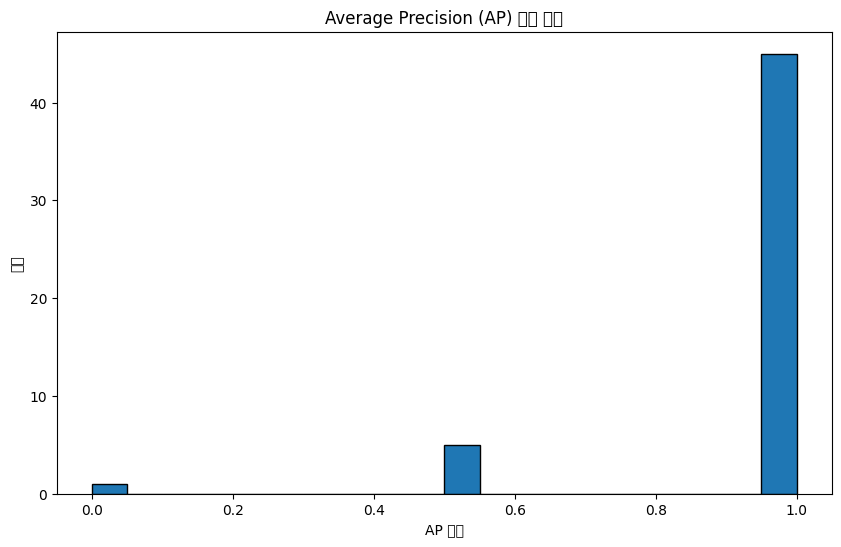


낮은 AP 점수를 가진 쿼리:
쿼리 인덱스: 10, AP 점수: 0.0000
쿼리: 피고인은 원심에서 선고된 형(징역 8개월)이 과중하다며 항소하였다. 원심법원은 피고인이 불출석한 상태에서 심리를 진행하고 판결을 내렸다. 피고인은 상소권회복청구를 하였고, 법원은 피고인이 책임질 수 없는 사유로 상소기간 내에 상소하지 못한 것으로 인정하여 상소권회복 결정을 하였다. 이에 따라, 피고인은 책임질 수 없는 사유로 원심의 공판절차에 출석할 수 없었으므로 원심판결에는 재심청구의 사유가 있었다. 이는 항소이유인 '재심청구의 사유가 있는 때'에 해당하므로, 항소심인 이 법원은 새로운 소송절차를 진행하고 새로운 심리 결과에 따라 다시 판결해야 한다. 따라서 원심판결은 파기되었다. 이후 법원은 변론을 거쳐 새로운 판결을 내렸다.
관련 문서 번호: 585
---


In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def calculate_ap(relevant_docs, search_results_indices, k=None):
    if k is not None:
        search_results_indices = search_results_indices[:k]
    
    relevant_set = set(relevant_docs)
    ap_sum = 0
    num_relevant = 0
    
    for i, doc_index in enumerate(search_results_indices, 1):
        if doc_index in relevant_set:
            num_relevant += 1
            precision = num_relevant / i
            ap_sum += precision
    
    if len(relevant_set) > 0:
        return ap_sum / len(relevant_set)
    return 0

def evaluate_with_relevant_docs(relevant_docs_df, df, chunk_embeddings, chunk_to_doc, top_k=5, bm25_weight=0.5, cosine_weight=0.5):
    ap_scores = []
    for _, row in relevant_docs_df.iterrows():
        query_text = row['요약']
        relevant_doc_indices = [row['번호']]  # 여러 개의 관련 문서가 있을 경우 이 부분을 수정
        
        # 하이브리드 검색 결과 가져오기
        hybrid_results = hybrid_cc(query_text, df, bm25_weight=bm25_weight, cosine_weight=cosine_weight, top_k=top_k)
        
        # 하이브리드 검색 결과에서 '번호' 컬럼 추출
        search_results_indices = [result['번호'] for result in hybrid_results]
        
        # AP 계산
        ap = calculate_ap(relevant_doc_indices, search_results_indices, k=top_k)
        ap_scores.append(ap)
    
    return {
        "Mean AP (MAP)": np.mean(ap_scores),
        "AP Scores": ap_scores
    }

# 데이터 분할
train_docs, test_docs = train_test_split(relevant_docs, test_size=0.2, random_state=42)

# 학습 세트에 대한 평가
train_results = evaluate_with_relevant_docs(train_docs, df, chunk_embeddings, chunk_to_doc)
print(f"Train Mean Average Precision (MAP): {train_results['Mean AP (MAP)']:.4f}")

# 테스트 세트에 대한 평가
test_results = evaluate_with_relevant_docs(test_docs, df, chunk_embeddings, chunk_to_doc)
print(f"Test Mean Average Precision (MAP): {test_results['Mean AP (MAP)']:.4f}")

# MAP@K 계산
for k in [1, 3, 5, 10]:
    results_at_k = evaluate_with_relevant_docs(relevant_docs, df, chunk_embeddings, chunk_to_doc, top_k=k)
    print(f"MAP@{k}: {results_at_k['Mean AP (MAP)']:.4f}")

# AP 분포 확인
ap_scores = results_at_k['AP Scores']
print("\nAP 점수 분포:")
print(f"최소값: {min(ap_scores):.4f}")
print(f"최대값: {max(ap_scores):.4f}")
print(f"중앙값: {np.median(ap_scores):.4f}")
print(f"평균: {np.mean(ap_scores):.4f}")
print(f"표준편차: {np.std(ap_scores):.4f}")

# AP 히스토그램 생성
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(ap_scores, bins=20, edgecolor='black')
plt.title('Average Precision (AP) 점수 분포')
plt.xlabel('AP 점수')
plt.ylabel('빈도')
plt.show()

# 낮은 AP 점수를 가진 쿼리 분석
low_ap_threshold = 0.5  # 이 값을 조정하여 "낮은" AP의 기준을 변경할 수 있습니다
low_ap_queries = [(i, score) for i, score in enumerate(ap_scores) if score < low_ap_threshold]

print("\n낮은 AP 점수를 가진 쿼리:")
for i, score in low_ap_queries[:5]:  # 처음 5개만 출력
    print(f"쿼리 인덱스: {i}, AP 점수: {score:.4f}")
    print(f"쿼리: {relevant_docs.iloc[i]['요약']}")
    print(f"관련 문서 번호: {relevant_docs.iloc[i]['번호']}")
    print("---")

In [52]:
def evaluate_with_relevant_docs(relevant_docs_df, df, chunk_embeddings, chunk_to_doc, top_k=5, bm25_weight=0.5, cosine_weight=0.5):
    ap_scores = []
    for _, row in relevant_docs_df.iterrows():
        query_text = row['요약']
        # 여러 개의 관련 문서를 고려합니다. 이 부분은 데이터셋에 따라 조정이 필요합니다.
        relevant_doc_indices = [row['번호']] + [row.get(f'관련문서_{i}', -1) for i in range(1, 5) if row.get(f'관련문서_{i}', -1) != -1]
        
        hybrid_results = hybrid_cc(query_text, df, bm25_weight=bm25_weight, cosine_weight=cosine_weight, top_k=top_k)
        search_results_indices = [result['번호'] for result in hybrid_results]
        
        ap = calculate_ap(relevant_doc_indices, search_results_indices, k=top_k)
        ap_scores.append(ap)
    
    return {
        "Mean AP (MAP)": np.mean(ap_scores),
        "AP Scores": ap_scores
    }

# 데이터셋에 관련 문서를 추가하는 예시 (실제 데이터에 맞게 조정 필요)
def add_related_docs(relevant_docs):
    for i, row in relevant_docs.iterrows():
        # 예시: 원래 문서 번호와 가까운 번호를 관련 문서로 추가
        relevant_docs.at[i, '관련문서_1'] = row['번호'] + 1
        relevant_docs.at[i, '관련문서_2'] = row['번호'] - 1
        relevant_docs.at[i, '관련문서_3'] = row['번호'] + 2
        relevant_docs.at[i, '관련문서_4'] = row['번호'] - 2
    return relevant_docs

# 관련 문서 추가
relevant_docs = add_related_docs(relevant_docs)

# 평가 실행
results = evaluate_with_relevant_docs(relevant_docs, df, chunk_embeddings, chunk_to_doc)
print(f"New Mean Average Precision (MAP): {results['Mean AP (MAP)']:.4f}")

New Mean Average Precision (MAP): 0.1902



새로운 AP 점수 분포:
최소값: 0.0000
최대값: 0.4000
중앙값: 0.2000
평균: 0.1902
표준편차: 0.0495


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49352 (\N{HANGUL SYLLABLE SAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPy

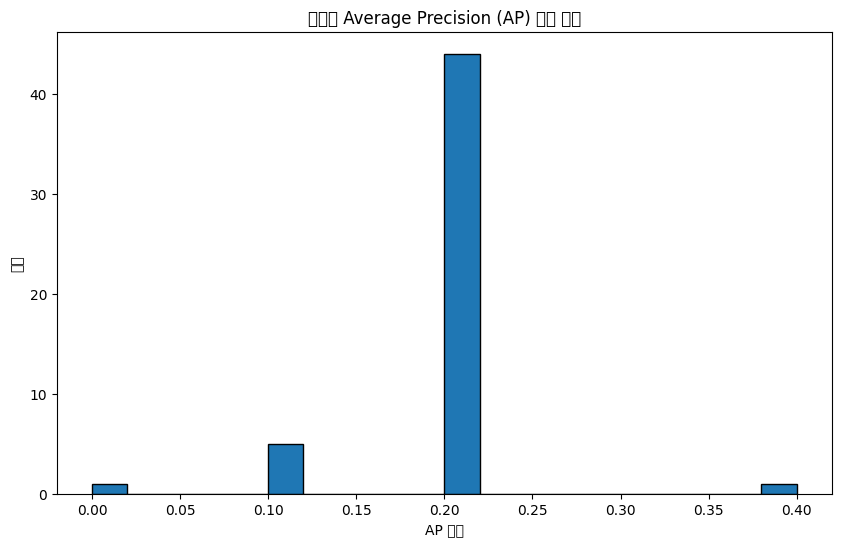

In [53]:

# AP 분포 재분석
ap_scores = results['AP Scores']
print("\n새로운 AP 점수 분포:")
print(f"최소값: {min(ap_scores):.4f}")
print(f"최대값: {max(ap_scores):.4f}")
print(f"중앙값: {np.median(ap_scores):.4f}")
print(f"평균: {np.mean(ap_scores):.4f}")
print(f"표준편차: {np.std(ap_scores):.4f}")

# 새로운 AP 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(ap_scores, bins=20, edgecolor='black')
plt.title('새로운 Average Precision (AP) 점수 분포')
plt.xlabel('AP 점수')
plt.ylabel('빈도')
plt.show()

Best Parameters: {'bm25_weight': 0.5, 'cosine_weight': 0.5, 'top_k': 20}
Best MAP: 0.1927

Final MAP: 0.1927
Top 5 Performing Queries:
AP: 0.2000, Query: 피고인은 2012년부터 2015년까지 여러 피해자들에게 건물 경매, 투자신탁 등을 이용한 사기를 계획하였습니다. 피고인은 피해자들에게 자신이 법원 경매나 투자신탁에 관련된 사람이라...
AP: 0.2000, Query: 피고인은 여러 차례에 걸쳐 다수의 피해자에게 상해 및 폭행을 가한 혐의로 기소되었습니다. 피고인은 자신의 행위가 피해자들에게 상해를 입히지 않았다며 항소하였습니다. 그러나 법원은 ...
AP: 0.2211, Query: 피고인은 2008년 12월에 부산 연제구 자신의 집에서 피해자를 성폭행하고, 피해자의 체크카드를 강취하여 현금을 인출한 혐의로 기소되었습니다. 피고인은 피해자와의 성관계는 동의하에...
AP: 0.2267, Query: 2022년 9월 26일, 피고인은 창원시 마산합포구의 'C'라는 장소에서 안마를 받던 중 피해자 D(여, 67세)를 손바닥으로 수회 때렸습니다. 피해자가 도망가자 피고인은 피해자를...
AP: 0.4000, Query: 1972년에 피고인이 술집에서 박정희 대통령에 대한 비판적 발언을 한 사건에 대해, 당시 계엄보통군법회의에서 피고인에게 징역 3년을 선고하였다. 피고인은 이에 대해 항소하였고, 육...

Bottom 5 Performing Queries:
AP: 0.0143, Query: 피고인은 원심에서 선고된 형(징역 8개월)이 과중하다며 항소하였다. 원심법원은 피고인이 불출석한 상태에서 심리를 진행하고 판결을 내렸다. 피고인은 상소권회복청구를 하였고, 법원은 ...
AP: 0.1000, Query: 피고인은 오토바이 퀵서비스업자로, 지정차로 위반으로 경찰에 단속되었습니다. 단속 과정에서 피고인은 오토바이 시동을 걸고 경찰을 약 10m 끌

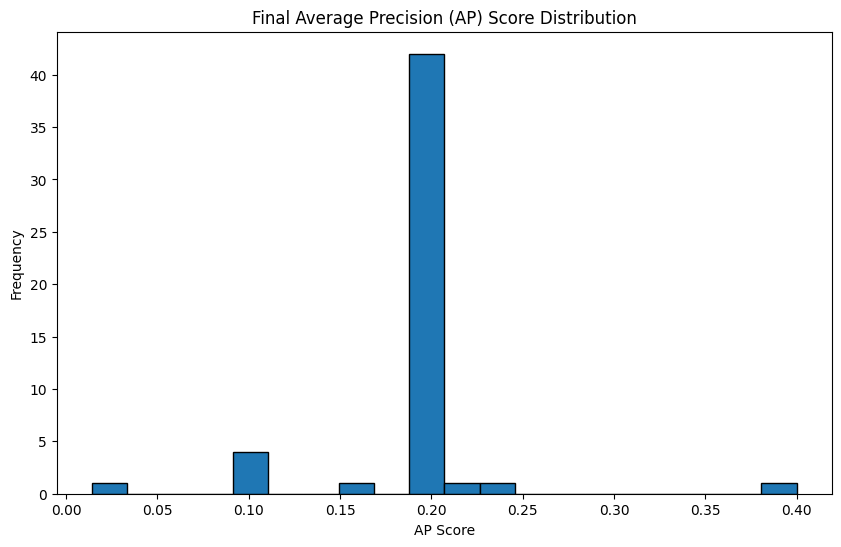

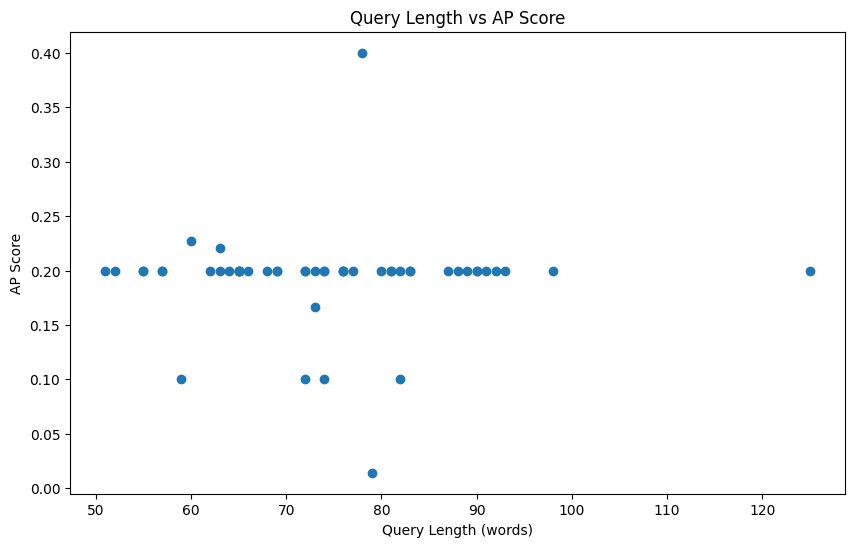


Correlation between query length and AP score: 0.0099


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

def evaluate_with_relevant_docs(relevant_docs_df, df, chunk_embeddings, chunk_to_doc, top_k=5, bm25_weight=0.5, cosine_weight=0.5):
    ap_scores = []
    query_results = []
    for _, row in relevant_docs_df.iterrows():
        query_text = row['요약']
        relevant_doc_indices = [row['번호']] + [row.get(f'관련문서_{i}', -1) for i in range(1, 5) if row.get(f'관련문서_{i}', -1) != -1]
        
        hybrid_results = hybrid_cc(query_text, df, bm25_weight=bm25_weight, cosine_weight=cosine_weight, top_k=top_k)
        search_results_indices = [result['번호'] for result in hybrid_results]
        
        ap = calculate_ap(relevant_doc_indices, search_results_indices, k=top_k)
        ap_scores.append(ap)
        query_results.append({
            'query': query_text,
            'ap_score': ap,
            'relevant_docs': relevant_doc_indices,
            'retrieved_docs': search_results_indices
        })
    
    return {
        "Mean AP (MAP)": np.mean(ap_scores),
        "AP Scores": ap_scores,
        "Query Results": query_results
    }

def analyze_performance(results):
    query_results = results['Query Results']
    sorted_results = sorted(query_results, key=lambda x: x['ap_score'])
    
    print("Top 5 Performing Queries:")
    for result in sorted_results[-5:]:
        print(f"AP: {result['ap_score']:.4f}, Query: {result['query'][:100]}...")
    
    print("\nBottom 5 Performing Queries:")
    for result in sorted_results[:5]:
        print(f"AP: {result['ap_score']:.4f}, Query: {result['query'][:100]}...")

def parameter_tuning(relevant_docs_df, df, chunk_embeddings, chunk_to_doc):
    param_grid = {
        'bm25_weight': np.arange(0.1, 1.0, 0.1),
        'cosine_weight': np.arange(0.1, 1.0, 0.1),
        'top_k': [3, 5, 10, 20]
    }
    
    best_map = 0
    best_params = None
    
    for params in ParameterGrid(param_grid):
        if params['bm25_weight'] + params['cosine_weight'] != 1.0:
            continue  # 가중치 합이 1이 되도록 함
        
        results = evaluate_with_relevant_docs(
            relevant_docs_df, df, chunk_embeddings, chunk_to_doc,
            top_k=params['top_k'],
            bm25_weight=params['bm25_weight'],
            cosine_weight=params['cosine_weight']
        )
        
        if results['Mean AP (MAP)'] > best_map:
            best_map = results['Mean AP (MAP)']
            best_params = params
    
    print(f"Best Parameters: {best_params}")
    print(f"Best MAP: {best_map:.4f}")
    return best_params

# 메인 실행 코드
best_params = parameter_tuning(relevant_docs, df, chunk_embeddings, chunk_to_doc)

# 최적 파라미터로 최종 평가
final_results = evaluate_with_relevant_docs(
    relevant_docs, df, chunk_embeddings, chunk_to_doc,
    top_k=best_params['top_k'],
    bm25_weight=best_params['bm25_weight'],
    cosine_weight=best_params['cosine_weight']
)

print(f"\nFinal MAP: {final_results['Mean AP (MAP)']:.4f}")

# 성능 분석
analyze_performance(final_results)

# AP 점수 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(final_results['AP Scores'], bins=20, edgecolor='black')
plt.title('Final Average Precision (AP) Score Distribution')
plt.xlabel('AP Score')
plt.ylabel('Frequency')
plt.show()

# 쿼리 길이와 AP 점수의 상관관계 분석
query_lengths = [len(result['query'].split()) for result in final_results['Query Results']]
ap_scores = [result['ap_score'] for result in final_results['Query Results']]

plt.figure(figsize=(10, 6))
plt.scatter(query_lengths, ap_scores)
plt.title('Query Length vs AP Score')
plt.xlabel('Query Length (words)')
plt.ylabel('AP Score')
plt.show()

# 상관계수 계산
correlation = np.corrcoef(query_lengths, ap_scores)[0, 1]
print(f"\nCorrelation between query length and AP score: {correlation:.4f}")

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/kaggle/input/law-data-merge/merge_1_7_Deduplication_cleaned_index.csv')

In [67]:
# 특정 행 출력 (예시)
pd.set_option('display.max_colwidth', None)
row_index = 5053
print(df.at[row_index, '전문'])

범 죄 사 실 피고인은 2017. 11. 4. 23:00경 서울 영등포구 영등포로 204 소재 포장마차에서 술을 마시던 중, 옆 테이블에 있던 피해자 강○○(남, 48세)이 시끄럽게 떠든다는 이유로 피해자와 욕설을 주고받다가 그곳에 있던 소주잔과 소주병을 피해자를 향해 집어 던지고, 포장마차에서 나와 서울 영등포구 영신로 소재 피고인이 거주하는 *고시원으로 들어가 그곳 부엌에서 위험한 물건인 식칼(총길이 31cm, 칼날길이  18.5cm)을 들고 다시 포장마차로 가서 식칼로 그 곳에 있던 피해자의 이마 부위를 1회 내리치고 식칼을 휘둘러 피해자의 왼쪽 손목을 베는 등 피해자에게 약 3주간의 치료를 요하는 얼굴 부위 열상 등을 가하였다. 피고인은 이와 같이 위험한 물건을 휴대하여 피해자를 상해하였다. 증거의 요지 생략 법령의 적용 1. 범죄사실에 대한 해당법조 형법 제258조의2 제1항, 제257조 제1항 1. 몰수 형법 제48조 제1항 제1호
